In [ ]:
from Utils import * 
from param_tools import *
import pickle
import matplotlib

import vedo
from vedo import Plotter, Sphere, Line

vedo.settings.default_backend="vtk" # for plotting in Jupyter Notebook

In [94]:
## Select Parameters

n_pts = 50 
noise = 0.05 #add gaussain noise
energyType = 1 # 0:harmonic, 1:spring
S = 0 # rest length of spring
K = 1e2 # spring constant
n_steps = 500 # number of optimization steps
alpha = 1e-5 # need to be much smaller for spring energy (1e-5 is reasonable for spring energy with K = 1e2)
intermediate_plots = 0 # generate some plots as the script runs for debugging purpose

In [95]:
## Generate data

np.random.seed(10)

data = generate_noisy_sphere(n_pts, radius=1, noise=noise)

In [96]:
# Get homological information from Ripser

max_barcode = 1 #off/on/SECOND Largest choice of barcode, overides choose and max_nhood if > 0, -1: smallest code
field = 11 # for computing cocycles
cocycles, distance_matrix, ripser_result = initial_ripser_calculation(data, field, plot=0)
if max_barcode != 0:
    choose = 0
    length = 0
    lengths = []
    n_sizes = []
    for i in range(0, len(cocycles[2][:])):
        birth = ripser_result['dgms'][2][i][0]
        death = ripser_result['dgms'][2][i][1]
        life = death - birth
        lengths.append(life)
        n_sizes.append((1 * death + 3 * birth) / 4)
    if max_barcode == 1:
        idx = np.argmax(lengths)
        choose = idx
        max_nhood_size = n_sizes[idx]
    if max_barcode == 2:
        n = 2
        idxes = [lengths.index(i) for i in sorted(lengths, reverse=True)][:n]
        idx = idxes[1]
        choose = idx
        max_nhood_size = n_sizes[idx]
    if max_barcode == -1:
        idx = np.argmin(lengths)
        choose = idx
        max_nhood_size = n_sizes[idx]
else:
    birth = ripser_result['dgms'][2][choose][0]
    death = ripser_result['dgms'][2][choose][1]
    max_nhood_size = (death + 3 * birth) / 4

selected_cocycle = cocycles[2][choose]
simplices, values = dim_2_get_edges_and_cohomology_info(distance_matrix, selected_cocycle, max_nhood_size)
trg_list = np.fliplr(np.array(simplices))

Sum of Values:84
Choose:0


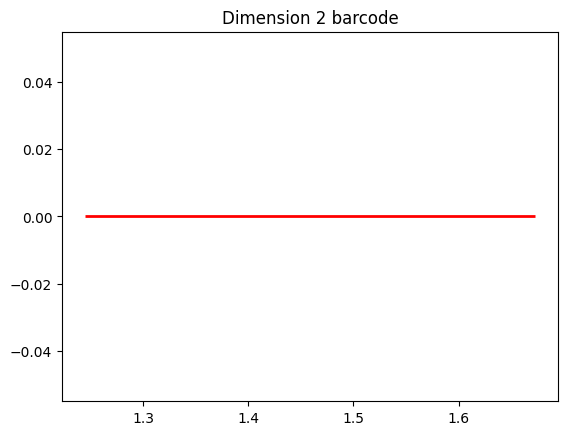

In [97]:
# Make barcode
sum_val = np.sum(values)
print('Sum of Values:'+str(sum_val))
plt.figure()
for i in range(0, len(cocycles[2][:])):
    birth = ripser_result['dgms'][2][i][0]
    death = ripser_result['dgms'][2][i][1]
    if i == choose:
        plt.hlines(y=i, xmin=birth, xmax=death, linewidth=2, color='r')
        print('Choose:'+str(i))
    else:
        plt.hlines(y=i, xmin=birth, xmax=death, linewidth=2, color='k')
plt.title('Dimension 2 barcode')
plt.show()

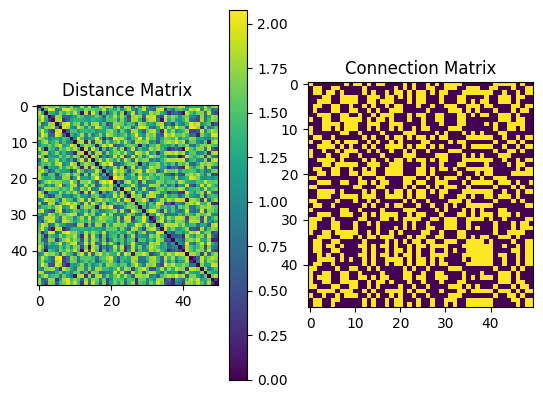

Values are:[ 0  1 10]  N Trgs:2585  Nonzero:12


In [98]:
## Plot initial data
initial_plot = 1
if initial_plot == 1:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(distance_matrix)
    plt.colorbar()
    plt.title('Distance Matrix')
    plt.subplot(1,2,2)
    connection_matrix = distance_matrix.copy()
    connection_matrix[distance_matrix < max_nhood_size] = 1
    connection_matrix[distance_matrix > max_nhood_size] = 0
    plt.imshow(connection_matrix)
    plt.title('Connection Matrix')
    plt.show()
    print('Values are:' + str(np.unique(values)) + '  N Trgs:' + str(len(trg_list)) + '  Nonzero:' + str(np.count_nonzero(values)))

Setting up points and barycenters


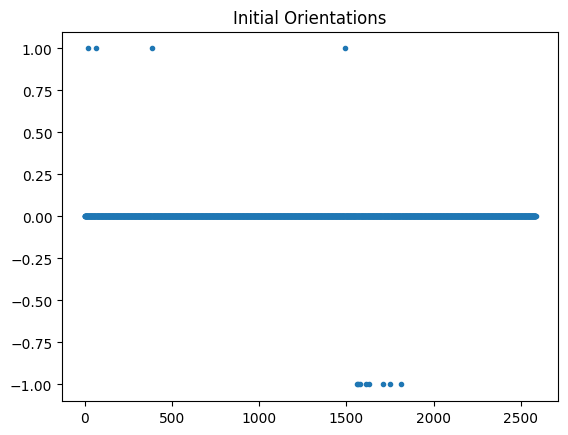

In [99]:
## Barycenters and points
print('Setting up points and barycenters')
bary = np.zeros(trg_list.shape)
orient = np.zeros(len(trg_list))
for i in range(len(trg_list)):
    if values[i] == 0:
        bary[i, :] = [1, 0, 0]
    else:
        bary[i, :] = [-1, 0, 0]
        if values[i] == 1:
            orient[i] = 1
        else:
            orient[i] = -1
pts = np.zeros([len(data), 3])
pts[:,0] = 1
plt.figure()
plt.plot(orient, '.')
plt.title('Initial Orientations')
plt.show()

Beginning Minimization
0 3665.3076305786394
1 3662.1112544743705
2 3654.635337259453
3 3643.7349742629935
4 3629.5337038193084
5 3611.8464139336497
6 3590.2099518495065
7 3563.8135790493143
8 3531.3314852869157
9 3490.5888558505453
10 3437.881414864707
11 3366.4791029883895
12 3262.9842811801927
13 3097.7526754328314
14 2807.47284402946
15 2383.9245759849764
16 2031.373982105708
17 1763.0329294262558
18 1622.784776276747
19 1568.3061454041097
20 1543.3873233114618
21 1530.944218483092
22 1520.9170354204662
23 1512.7282118359808
24 1505.9764731451664
25 1500.332114522302
26 1495.5341666601105
27 1491.380731151658
28 1487.716962007186
29 1484.4238904292665
30 1481.409568710511
31 1478.6020348420823
32 1475.9440388758446
33 1473.3891853873622
34 1470.89902267344
35 1468.441894324712
36 1465.992049203329
37 1463.5234973854595
38 1461.011256437317
39 1458.4308309752453
40 1455.7568417973043
41 1452.9615100042613
42 1450.0125327547685
43 1446.8694479890817
44 1443.4762606366517
45 1440.14494

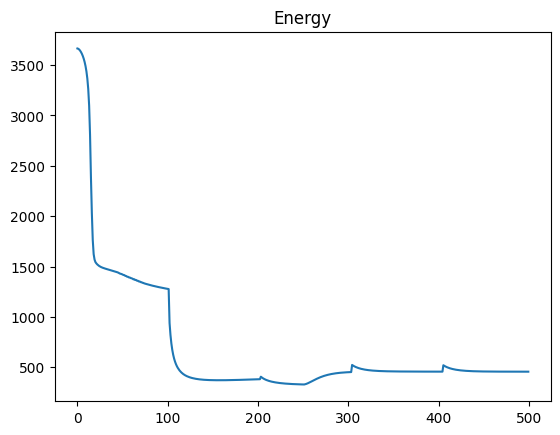

In [100]:
# Minimization
NRG = []

pts_history = np.zeros((n_steps, len(data), 3))
avg_grad = np.zeros(n_steps)

print('Beginning Minimization')
for i in range(n_steps):
    pts_history[i] = pts.copy()
    
    # Compute NRG
    E, E_list, A_list, grad = compute_grad_and_NRG(pts, trg_list, bary, orient, energyType, S, K)
    
    avg_grad[i] = np.mean(np.linalg.norm(grad, axis=1))
 
    NRG.append(E)
    if math.isnan(E):
        print('NAN at i='+str(i))
        break
    # update Grad
    pts, bary = compute_grad_step(pts, trg_list, grad, bary, alpha, i)
    
    print(i, E)
    # if i % (n_steps // 5) == 0:
    #     if dataType == 0 or dataType == 2 or dataType == 3 or dataType == 4:
    #         plot_data_and_results(data, pts, title=str(i))
    #     plt.show()
    if i > 1:
        if NRG[-2] < NRG[-1]:
            print('Increasing at '+str(i))
            #break

# converge
plt.figure()
plt.plot(np.arange(len(NRG)), NRG)
plt.title('Energy')
plt.show()

In [101]:
edge_pairs = [(i, j) for i in range(n_pts) for j in range(i + 1, n_pts) if connection_matrix[i, j] == 1]
num_edges = len(edge_pairs)

line_history = np.zeros((n_steps, num_edges, 50, 3), dtype=np.float64)

for t, pts_step in enumerate(pts_history):
    for k, (i, j) in enumerate(edge_pairs):
        p1 = pts_step[i]
        p2 = pts_step[j]
        path = great_circle_path(p1, p2)
        line_history[t, k] = path

In [102]:
sphere = Sphere(r=1, alpha=0.1)
point_actors = [Sphere(pos, r=0.02, c="blue") for pos in pts_history[0]]
line_actors = [Line(path, alpha=0.2) for path in line_history[0]]

plt_3d = Plotter(title='Optimization on Sphere', axes=1)
plt_3d.add(sphere)
plt_3d.add(*point_actors)

def update_slider(widget, event):
    step = int(widget.value * (len(pts_history) - 1))
    positions = pts_history[step]
    for actor, pos in zip(point_actors, positions):
        actor.pos(pos)
        
    new_line_actors = [Line(path, alpha=0.2) for path in line_history[step]]
    
    plt_3d.remove(*line_actors)
    line_actors.clear()
    line_actors.extend(new_line_actors) 
    plt_3d.add(*line_actors)

slid = plt_3d.add_slider(
    update_slider,         
    xmin=0.0,              
    xmax=1.0,              # range max (1.0)
    value=0.0,             # initial slider value
    slider_length=0.02,    
    slider_width=0.03,     
    alpha=0.5,             
    tube_width=0.005,      
    pos='bottom-left',
    show_value=True
)

plt_3d.show(*point_actors, sphere, viewup="z")

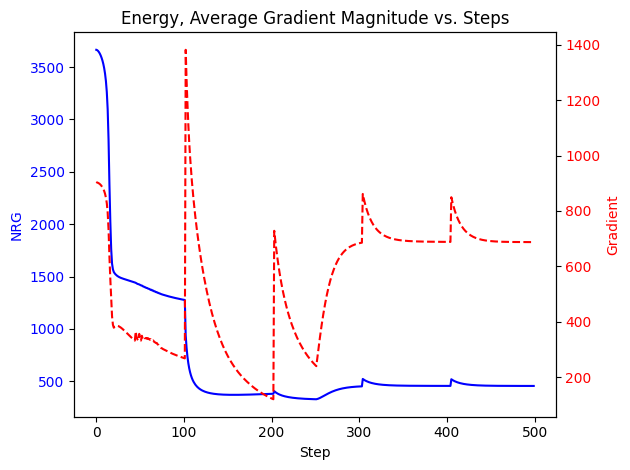

In [103]:
fig, ax1 = plt.subplots()

# Plot NRG on the primary y-axis (left)
ax1.plot(np.arange(len(NRG)), NRG, label='NRG', color='blue')
ax1.set_xlabel('Step')
ax1.set_ylabel('NRG', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis (right) for gradients
ax2 = ax1.twinx()
ax2.plot(np.arange(len(avg_grad)), avg_grad, label='Gradient', color='red', linestyle='--')
ax2.set_ylabel('Gradient', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Energy, Average Gradient Magnitude vs. Steps')
fig.tight_layout()
plt.show()